# シングルネットワーク用のnotebook
精度を求めるために基本的にはデュアルのネットワークを利用すれば良いが、比較のために用意している。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from numba import jit

from tqdm import tqdm
import os
%matplotlib inline

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='0'
# import keras

In [3]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Layer,Lambda
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

In [5]:
imheight = 128
imwidth = 128
channels = 3
ALPHA = 0.1
BETA = 0.05
dense_num = 512
vec_length = 512
category = 'Coat'

In [6]:
from keras.applications.vgg16 import VGG16
#include_top=false => Dense不要
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(imwidth, imheight, channels)), input_shape=None) 

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
for layer in base_model.layers[:15]:
    layer.trainable=False

In [8]:
def create_embNet():
    x = base_model.output
    conv1 = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    conv2 = Conv2D(filters=32, kernel_size=(3,3) , padding='same', activation='relu')(conv1)
    flatten = Flatten()(conv2) 
    dense_layer = Dense(dense_num, activation='relu')(flatten)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
    return  Model(inputs=[base_model.input], outputs=norm_layer)

In [9]:
# define three Inputs
a_in = Input(shape = (imheight, imwidth, channels), name='anchor_input')
p_in = Input(shape = (imheight, imwidth, channels), name='positive_input')
n_in = Input(shape = (imheight, imwidth, channels), name='negative_input')

In [10]:
# 学習後にベクトルのencoderとして利用するので外に定義する。
con_embNet = create_embNet()
shop_embNet = create_embNet()

In [11]:
a_emb = shop_embNet(a_in)
p_emb = con_embNet(p_in)
n_emb = con_embNet(n_in)

In [12]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = {'alpha': self.alpha}
        base_config = super(TripletLossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [13]:
class ImprovedTripletLossLayer(Layer):
    def __init__(self, alpha, beta, **kwargs):
        self.alpha = alpha
        self.beta = beta
        super(ImprovedTripletLossLayer, self).__init__(**kwargs)

    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        pn_dist = K.sum(K.square(p-n), axis=-1)
        return K.sum(K.maximum((p_dist - n_dist + self.alpha), 0) + K.maximum((p_dist - self.beta), 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = {'alpha': self.alpha}
        base_config = super(TripletLossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
con_embNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

## triplet lossの選択を忘れずに

In [29]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
# triplet_loss_layer = TripletLossLayer(alpha=ALPHA,name='triplet_loss_layer')([a_emb, p_emb, n_emb])
triplet_loss_layer = ImprovedTripletLossLayer(alpha=ALPHA,beta=BETA,name='triplet_loss_layer')([a_emb, p_emb, n_emb])

# Model that can be trained with anchor, positive negative images
tripletNet = Model([a_in, p_in, n_in], triplet_loss_layer)

# complie
tripletNet.compile(loss=None, optimizer='adam')

In [16]:
tripletNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 512)          15134080    anchor_input[0][0]               
__________________________________________________________________________________________________
model_1 (M

In [17]:
from keras.utils import plot_model
plot_model(tripletNet, to_file='model.png')

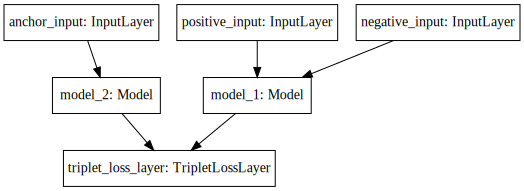

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(tripletNet).create(prog='dot', format='svg'))

### データの用意

In [43]:
BASE_PATH = './dataset/crop_img/img/TOPS/Coat/'
ids_ = sorted([x for x in os.listdir(BASE_PATH)])

In [44]:
ids_[0]

'id_00000002'

In [45]:
len(ids_)

2432

In [46]:
import shutil
def rmdir(ids,PATH):
    for id_ in ids:
        files = sorted([BASE_PATH+id_+'/'+x for x in os.listdir(BASE_PATH+id_)])
        con = sorted([x for x in files if 'comsumer' in x])
        shop = sorted([x for x in files if 'shop' in x ])
        if len(con)==0 or len(shop)==0:
            shutil.rmtree(PATH+id_)
    return os.listdir(BASE_PATH)

In [47]:
ids = sorted([x for x in rmdir(ids_,BASE_PATH)])

### tripletのパスの組を返す関数

In [48]:
import itertools
import random
def get_triplets(ids,BASE_PATH):
    triplets=[]
    for id_ in tqdm(ids):
        files = sorted([BASE_PATH+id_+'/'+x for x in os.listdir(BASE_PATH+id_)])
        con = sorted([x for x in files if 'comsumer' in x])
        shop = sorted([x for x in files if 'shop' in x ])
        combs = list(itertools.product(tuple(con),tuple(shop)))
        for comb in combs:
            comb = list(comb)
            neg_id = random.choice([x for x in ids if x != id_])
            neg_file = random.choice([BASE_PATH+neg_id+'/'+x for x in os.listdir(BASE_PATH+neg_id) if 'shop' in x])
            comb.append(neg_file)
            triplets.append(comb)
    return triplets

### id単位でtrainとtestを分割する
- 元々np.random.choice()でやっていたが、ブートストラップサンプリングだったのでダメ
- train_test_splitを利用

In [49]:
from sklearn.cross_validation import train_test_split
# from sklearn.model_selection import ShuffleSplit

In [50]:
# random_stateを固定しておく
train_ids,test_ids=train_test_split(ids,test_size=0.33,random_state=0)
del ids

In [51]:
train_ids[:5]

['id_00011168', 'id_00016640', 'id_00027543', 'id_00020250', 'id_00014516']

In [52]:
from PIL import Image
def get_np_triplets(triplet_PATHs):
    triplets = []
    for triplet in tqdm(triplet_PATHs):
        anc_img = Image.open(triplet[0]).convert('RGB')
        pos_img = Image.open(triplet[1]).convert('RGB')
        neg_img = Image.open(triplet[2]).convert('RGB')

        anc_img = np.array(anc_img.resize((128,128)))/255. #resize to (128,128,3)
        pos_img = np.array(pos_img.resize((128,128)))/255.    
        neg_img = np.array(neg_img.resize((128,128)))/255.    

        tri = [anc_img,pos_img,neg_img]
        triplets.append(np.array(tri))
    triplets = np.array(triplets)
    return triplets

test_idsはretrival.ipynbで参照するのでpickleとして保存

In [53]:
import pickle
f = open('./pickle/{}/test_ids.pickle'.format(category), 'wb')
pickle.dump(test_ids, f)

## 学習

In [30]:
epochs = 100
# model_dir ='./model/{}/Single_normal/a{}'.format(category,ALPHA)
model_dir = './model/{}/Single_improved/a{}b{}'.format(category,ALPHA,BETA)
os.listdir(model_dir)

['.ipynb_checkpoints', '512']

各エポックでtestデータを用いてN-top accを出したい→けど結果としてはいらない？
- epochの外でtrain,testに分割するパターンなので常にtestのidは同じ
- 5epochに一度tripletを更新する
- model.fitはepochs=1で行う

In [31]:
model_history = []
for epoch in range(epochs):
    print('epoch %s'% epoch)
    if epoch % 5 == 0:
        if epoch != 0: del triplets
        triplets_train_PATHs = get_triplets(train_ids,BASE_PATH)
        triplets = get_np_triplets(triplets_train_PATHs)
        del triplets_train_PATHs
    # fit
    hist = tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=1, batch_size=50)
    model_history.append(hist.history)
    f = open(model_dir+'/{}/history{}.txt'.format(vec_length,epoch),'wb')
    pickle.dump(model_history, f)
    # 使い終わったので削除
##    del triplets
    if (epoch+1) % 5 == 0:
        shop_embNet.save(model_dir+'/{}/shop_e{}.h5'.format(vec_length,epoch))
        con_embNet.save(model_dir+'/{}/con_e{}.h5'.format(vec_length,epoch))
# 学習のhistoryを保存
f = open(model_dir+'/{}/history.txt'.format(vec_length),'wb')
pickle.dump(model_history, f)

  0%|          | 8/1630 [00:00<00:21, 76.79it/s]

epoch 0


100%|██████████| 17327/17327 [01:53<00:00, 152.32it/s]


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
17327/17327 [==============================] - 55s 3ms/step - loss: 5.1542
epoch 1
Epoch 1/1
17327/17327 [==============================] - 51s 3ms/step - loss: 3.7410
epoch 2
Epoch 1/1
17327/17327 [==============================] - 51s 3ms/step - loss: 3.3602
epoch 3
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 3.0403
epoch 4
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 2.7493


  1%|          | 15/1630 [00:00<00:12, 131.39it/s]

epoch 5


100%|██████████| 17327/17327 [01:51<00:00, 157.00it/s]


Epoch 1/1
17327/17327 [==============================] - 51s 3ms/step - loss: 2.6956
epoch 6
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 2.3162
epoch 7
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 2.0217
epoch 8
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 1.7570
epoch 9
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 1.5407


  1%|          | 15/1630 [00:00<00:14, 109.94it/s]

epoch 10


100%|██████████| 17327/17327 [01:46<00:00, 162.23it/s]


Epoch 1/1
17327/17327 [==============================] - 50s 3ms/step - loss: 1.7625
epoch 11
Epoch 1/1
17327/17327 [==============================] - 50s 3ms/step - loss: 1.4418
epoch 12
Epoch 1/1
17327/17327 [==============================] - 51s 3ms/step - loss: 1.2230
epoch 13
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 1.0471
epoch 14
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.9220


  1%|          | 15/1630 [00:00<00:13, 123.51it/s]

epoch 15


100%|██████████| 17327/17327 [01:37<00:00, 177.81it/s]


Epoch 1/1
17327/17327 [==============================] - 51s 3ms/step - loss: 1.2456
epoch 16
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.9758
epoch 17
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.7961
epoch 18
Epoch 1/1
17327/17327 [==============================] - 51s 3ms/step - loss: 0.6767
epoch 19
Epoch 1/1
17327/17327 [==============================] - 49s 3ms/step - loss: 0.5834


  1%|          | 15/1630 [00:00<00:13, 116.94it/s]

epoch 20


100%|██████████| 17327/17327 [01:46<00:00, 162.82it/s]


Epoch 1/1
17327/17327 [==============================] - 51s 3ms/step - loss: 0.9800
epoch 21
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.7338
epoch 22
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.5720
epoch 23
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.4812
epoch 24
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.4175


  1%|          | 15/1630 [00:00<00:13, 119.36it/s]

epoch 25


100%|██████████| 17327/17327 [01:57<00:00, 147.01it/s]


Epoch 1/1
17327/17327 [==============================] - 51s 3ms/step - loss: 0.8052
epoch 26
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.5738
epoch 27
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.4714
epoch 28
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.3946
epoch 29
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.3233


  1%|          | 15/1630 [00:00<00:13, 123.12it/s]

epoch 30


100%|██████████| 17327/17327 [01:52<00:00, 153.91it/s]


Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.6904
epoch 31
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.4994
epoch 32
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.3910
epoch 33
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.3375
epoch 34
Epoch 1/1
17327/17327 [==============================] - 52s 3ms/step - loss: 0.2940


  1%|          | 15/1630 [00:00<00:13, 123.23it/s]

epoch 35


100%|██████████| 17327/17327 [01:52<00:00, 154.49it/s]


Epoch 1/1
17327/17327 [==============================] - 50s 3ms/step - loss: 0.6105
epoch 36
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.4213
epoch 37
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3386
epoch 38
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.2826
epoch 39
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.2469


  1%|          | 15/1630 [00:00<00:11, 134.98it/s]

epoch 40


100%|██████████| 17327/17327 [01:27<00:00, 197.03it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.5773
epoch 41
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3692
epoch 42
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.2964
epoch 43
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.2514
epoch 44
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.2226


  1%|          | 15/1630 [00:00<00:12, 128.75it/s]

epoch 45


100%|██████████| 17327/17327 [01:34<00:00, 183.54it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.5152
epoch 46
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3390
epoch 47
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.2605
epoch 48
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.2223
epoch 49
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1941


  1%|          | 15/1630 [00:00<00:11, 139.54it/s]

epoch 50


100%|██████████| 17327/17327 [01:33<00:00, 184.90it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.4708
epoch 51
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3108
epoch 52
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.2367
epoch 53
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1952
epoch 54
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1767


  1%|          | 19/1630 [00:00<00:08, 186.76it/s]

epoch 55


100%|██████████| 17327/17327 [01:33<00:00, 185.82it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.4610
epoch 56
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3201
epoch 57
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.2250
epoch 58
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1905
epoch 59
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1688


  1%|          | 20/1630 [00:00<00:08, 193.37it/s]

epoch 60


100%|██████████| 17327/17327 [01:21<00:00, 212.28it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.4422
epoch 61
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.2868
epoch 62
Epoch 1/1
17327/17327 [==============================] - 48s 3ms/step - loss: 0.2255
epoch 63
Epoch 1/1
17327/17327 [==============================] - 51s 3ms/step - loss: 0.1844
epoch 64
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1576


  1%|          | 20/1630 [00:00<00:08, 192.63it/s]

epoch 65


100%|██████████| 17327/17327 [01:24<00:00, 206.22it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3797
epoch 66
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.2459
epoch 67
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1874
epoch 68
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1505
epoch 69
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1409


  1%|          | 20/1630 [00:00<00:08, 190.42it/s]

epoch 70


100%|██████████| 17327/17327 [01:21<00:00, 212.07it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3993
epoch 71
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.2581
epoch 72
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1961
epoch 73
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1531
epoch 74
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1420


  1%|▏         | 23/1630 [00:00<00:07, 224.48it/s]

epoch 75


100%|██████████| 17327/17327 [01:33<00:00, 184.75it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3521
epoch 76
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.2235
epoch 77
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1690
epoch 78
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1329
epoch 79
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1193


  1%|          | 15/1630 [00:00<00:12, 134.51it/s]

epoch 80


100%|██████████| 17327/17327 [01:30<00:00, 191.02it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3530
epoch 81
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.2147
epoch 82
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.1605
epoch 83
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1339
epoch 84
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1134


  1%|          | 15/1630 [00:00<00:10, 147.79it/s]

epoch 85


100%|██████████| 17327/17327 [01:33<00:00, 184.47it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3386
epoch 86
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.2205
epoch 87
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.1505
epoch 88
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1156
epoch 89
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1005


  1%|          | 15/1630 [00:00<00:13, 123.82it/s]

epoch 90


100%|██████████| 17327/17327 [01:31<00:00, 189.90it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3278
epoch 91
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.1990
epoch 92
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1457
epoch 93
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1196
epoch 94
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1013


  1%|          | 15/1630 [00:00<00:13, 117.74it/s]

epoch 95


100%|██████████| 17327/17327 [01:34<00:00, 182.80it/s]


Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.3090
epoch 96
Epoch 1/1
17327/17327 [==============================] - 46s 3ms/step - loss: 0.1965
epoch 97
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1311
epoch 98
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.1114
epoch 99
Epoch 1/1
17327/17327 [==============================] - 47s 3ms/step - loss: 0.0932


In [30]:
# for epoch in range(epochs):
#     print('epoch %s'% epoch)
#     # PATHの組みを取得
#     triplets_train_PATHs = get_triplets(train_ids,BASE_PATH)
#     # np配列に変換
#     triplets = get_np_triplets(triplets_train_PATHs)
#     # fit
#     tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=1, batch_size=50) # using batch_size is better
#     # 使い終わったので削除
#     del triplets
#     if (epoch+1) % 5 == 0:
# #         tripletNet.save('./model/T_Shirt/Single/tripletNetmodel_e{}.h5'.format(epoch))
#         # 5epochごとにmodelを保存
#         shop_embNet.save('./model/T_Shirt/Single/a{}/{}/shop_emb_e{}.h5'.format(ALPHA,vec_length,epoch))
#         con_embNet.save('./model/T_Shirt/Single/a{}/{}/con_emb_e{}.h5'.format(ALPHA,vec_length,epoch))